# Importing
Before starting, run in terminal: 

```pip install mne[data]```

In [4]:
# importing modules
import os
import numpy as np
import mne

# Read in data

In [5]:
raw = mne.io.read_raw_brainvision("Group3_own.vhdr", eog=('EOG1', 'EOG2'), misc='auto', scale=1.0, preload=False, verbose=None)

# raw.info['bads'] = ['TP10', 'T7']

Extracting parameters from Group3_own.vhdr...
Setting channel info structure...


# Inspecting raw data

In [6]:
raw.load_data()

Reading 0 ... 751859  =      0.000 ...   751.859 secs...


<RawBrainVision | Group3_own.eeg, 32 x 751860 (751.9 s), ~183.6 MB, data loaded>

# Getting data info specific for our technique of measuring (10-20)

In [7]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)

<RawBrainVision | Group3_own.eeg, 32 x 751860 (751.9 s), ~183.6 MB, data loaded>

# Electrode map (10-20)

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


Matplotlib is building the font cache; this may take a moment.


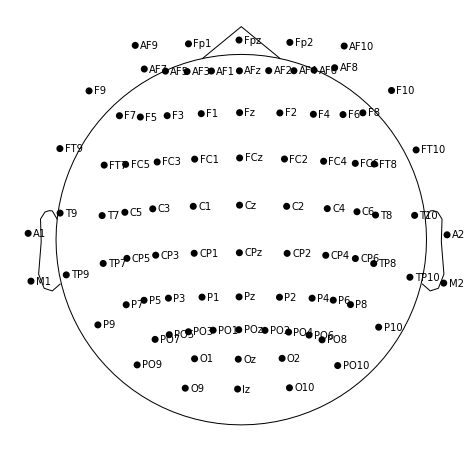

In [8]:
mne.viz.plot_montage(montage, scale_factor=20, show_names=True, kind='topomap', show=True, sphere=None, verbose=None);

# Active electrodes in present experiment
... if I wanna see the channels which was active in my experiment

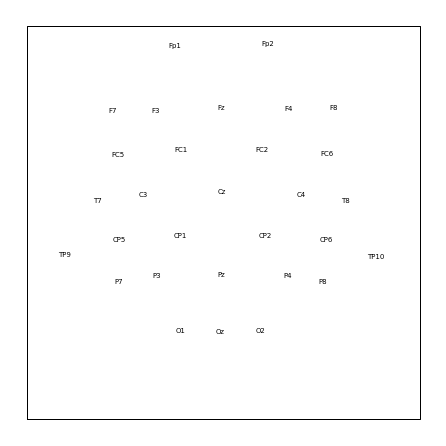

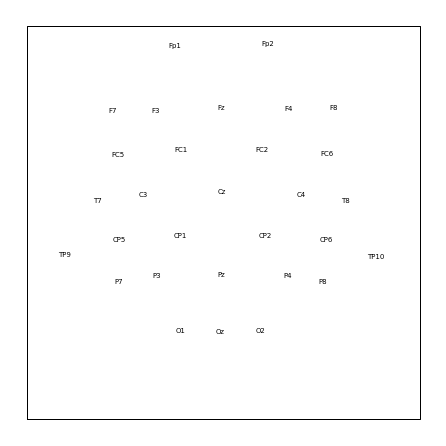

In [9]:
electrodes = mne.channels.make_eeg_layout(raw.info, radius=0.5, width=None, height=None, csd=False)

electrodes.plot() # dunno why two plots?

# View channels
Showing the first 100 sec of recognition phase

Opening raw-browser...


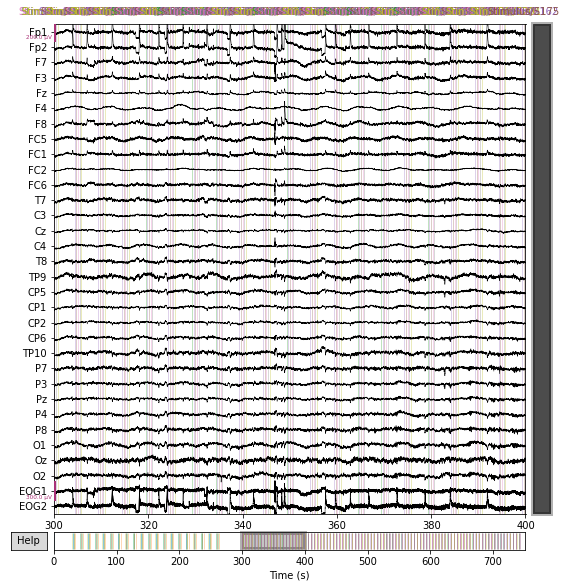

In [52]:
mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg = 1e-4), start = 300, duration = 100); 
# I zoom in the data with "start" and "duration"

# Filtering

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Opening raw-browser...


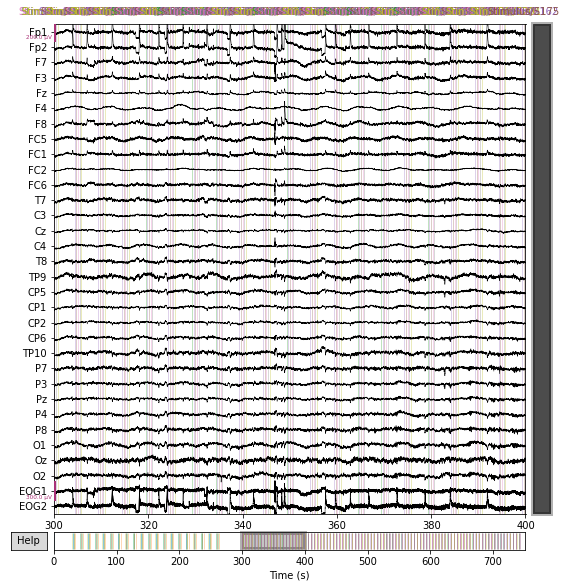

In [11]:
# high-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz
raw = raw.filter(0.1, None)
raw = raw.filter(None, 40)

# plotting the filtered data for inspection
#raw.plot(n_channels = 30, start = 0, duration = 20);

mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg = 1e-4), start = 300, duration = 100);

# Artefact removal
There are many ways to detect and deal with artefacts. Today, we simply select a value and reject anything above or below that value. We do this because we determine that values over or under this threshold are liekly not related to brain activity. For now, we just create the variable and then we use it to remove artefacts while epoching.

Opening raw-browser...


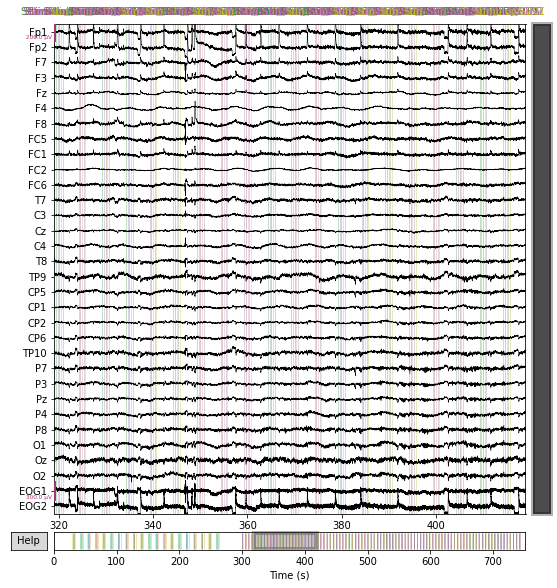

In [53]:
# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts
reject = dict(eeg=150e-6)

# plotting the data for inspection
#raw.plot(n_channels = 30, );

mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg = 1e-4), start = 319, duration = 100);

# Epoching

### Anotating triggers

In [13]:
#triggers = mne.events_from_annotations(raw)

triggers, triggers_list = mne.events_from_annotations(raw)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  6', 'Stimulus/S 12', 'Stimulus/S 25', 'Stimulus/S 39', 'Stimulus/S 47', 'Stimulus/S 51', 'Stimulus/S112', 'Stimulus/S125', 'Stimulus/S139', 'Stimulus/S147', 'Stimulus/S151', 'Stimulus/S162', 'Stimulus/S175', 'Stimulus/S189', 'Stimulus/S197', 'Stimulus/S201']


In [14]:
# read in trig_list - triggers from logfile
trig_list = np.genfromtxt('trig_list.csv', delimiter=',')

In [15]:
# number of triggers in that list
print(np.shape(trig_list))
# aligning first 10 triggers of both structures
[triggers[0:10,2], trig_list[0:10]]

(571,)


[array([99999,   112,   125,   139,   147,   151,     6,   112,   125,
          139]),
 array([nan,  2.,  5.,  9.,  7.,  1., 99.,  2.,  5.,  9.])]

In [16]:
# making a copy of our trig_list (except 1st nan-trigger) and setting trigger-99 to 6 in order to be able to compare 
# the training-set-triggers directly with our EEG-triggers
trig_list_temp = trig_list[1:].copy()
trig_list_temp = trig_list_temp.astype(int)
trig_list_temp[trig_list_temp==99] = 6
# also a copy of the 3rd column of the triggers-structure (except 1st 99999-trigger)
triggers_temp = triggers[1:,2].copy()
triggers_temp = triggers_temp % 10 # % means modulo - it's an operator that allows you to get the "rest" number after having divided with a given number (here 10)
# comparing the first 10 triggers of both temp-structures
(triggers_temp[0:10], trig_list_temp[0:10])

(array([2, 5, 9, 7, 1, 6, 2, 5, 9, 7]), array([2, 5, 9, 7, 1, 6, 2, 5, 9, 7]))

In [17]:
# getting the index of the first trigger that's not part of the learning phase (and we start from index 1 because or temp-structures don't include the first pseudo-trial)
learn_phase = np.argmax((triggers[1:,2]>151) | (triggers[1:,2]<112) & (triggers[1:,2]!=6))
# testing whether all triggers of the two vectors correspond from the beginning till then
all(triggers_temp[0:learn_phase]==trig_list_temp[0:learn_phase])

True

In [18]:
# THIS IS THE CRUCIAL STEP in creating and adapted triggers-structure:
# the logic is that for any values AFTER the learning phase, we simply subtract the modulo-values in triggers-temp from the triggers
# (cuz the trigger-temp-values are equivalent to the "ones" from the triggers-structure), and then we add the values from the logfile
new_triggers = triggers.copy()
new_triggers[learn_phase+1:,2] = new_triggers[learn_phase+1:,2]-triggers_temp[learn_phase:]+trig_list_temp[learn_phase:]

In [19]:
new_triggers[:,2] # just having a quick look at the "new" trigger-values

array([99999,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   112,   125,   139,   147,   151,
           6,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   112,   125,   139,   147,   151,
           6,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   112,   125,   139,   147,   151,
           6,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   112,   125,   139,   147,   151,
           6,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   112,   125,   139,   147,   151,
           6,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   112,   125,   139,   147,   151,
           6,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   162,   177,   183,   195,   206,
         162,   178,

In [23]:
# THIS IS WHERE WE RECODE THE TRIGGERS
# Now we want to be able to tell all the different incorrect sequences from each other
# And we know that they ALL uniquely start with 162 (cuz that's always the first number in an incrorrect sequence)
# And we also know that if the second trigger is 175 and third is not 189, then it's a sequence that is incorrect from its third place onwards (and then we add 50 to all triggers in those sequences)
# Same logic if the second and third triggers are 175 and 189, resp., and fourth is not 197, then it's a sequence that it's incorrect from its fourth place onwards (we add 100 to those)
# Same logic if the second to fourth triggers are 175, 189, 197 resp., and fifth is not 201, then it's a sequence that it's incorrect from its fifth place onwards (we add 150 to those)
incorr_idx = new_triggers[:,2] == 162 # getting a boolean index
incorr_rows = [i for i, x in enumerate(incorr_idx) if x] # getting the actual trial-numbers to have something to loop over
print(len(incorr_rows))
for i in incorr_rows:
    if (new_triggers[i+1,2]==175) & (new_triggers[i+2,2]!=189):
        #print('third')
        new_triggers[i:i+5,2] = new_triggers[i:i+5,2]+50
    elif (new_triggers[i+1,2]==175) & (new_triggers[i+2,2]==189) & (new_triggers[i+3,2]!=197):
        #print('fourth')
        new_triggers[i:i+5,2] = new_triggers[i:i+5,2]+100
    elif (new_triggers[i+1,2]==175) & (new_triggers[i+2,2]==189) & (new_triggers[i+3,2]==197) & (new_triggers[i+4,2]!=201):
        #print('fifth')
        new_triggers[i:i+5,2] = new_triggers[i:i+5,2]+150

27


In [24]:
np.unique(new_triggers[:,2]) # checking how many unique triggers we need to create event_ids for

array([    6,    12,    25,    39,    47,    51,   112,   125,   139,
         147,   151,   162,   171,   173,   174,   176,   177,   178,
         179,   181,   183,   184,   185,   186,   187,   188,   189,
         191,   193,   195,   196,   197,   198,   199,   201,   203,
         204,   205,   206,   207,   208,   209,   212,   225,   231,
         234,   236,   247,   248,   253,   259,   262,   275,   289,
         290,   291,   293,   294,   296,   298,   301,   303,   304,
         306,   307,   308,   312,   325,   339,   347,   353,   354,
         356, 99999])

In [25]:
new_event_id = {
 'Imagine': 6, # "Imagine"
 'recog_phase/corr/first/2': 12, # Number 1, recognition phase | correct
 'recog_phase/corr/second/5': 25, # Number 2, recognition phase | correct
 'recog_phase/corr/third/9': 39, # Number 3, recognition phase | correct
 'recog_phase/corr/fourth/7': 47, # Number 4, recognition phase | correct
 'recog_phase/corr/fifth/1': 51, # Number 5, recognition phase | correct
 'learn_phase/first/2': 112, # Number 1, learning phase
 'learn_phase/second/5': 125, # Number 2, learning phase
 'learn_phase/third/9': 139, # Number 3, learning phase
 'learn_phase/fourth/7': 147, # Number 4, learning phase
 'learn_phase/fifth/1': 151, # Number 5, learning phase
 'recog_phase/incorr2/first/2': 162, # Number 1, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/1': 171, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/3': 173, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/4': 174, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/6': 176, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/7': 177, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/8': 178, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/9': 179, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/1': 181, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/3': 183, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/4': 184, # Number 3, recognition phase | incorrect in place 2 
 'recog_phase/incorr2/third/5': 185, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/6': 186, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/7': 187, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/8': 188, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/9': 189, # Number 3, recognition phase | incorrect in place 2 
 'recog_phase/incorr2/fourth/1': 191, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/3': 193, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/5': 195, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/6': 196, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/7': 197, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/8': 198, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/9': 199, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/1': 201, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/3': 203, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/4': 204, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/5': 205, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/6': 206, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/7': 207, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/8': 208, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/9': 209, # Number 5, recognition phase | incorrect in place 2

 'recog_phase/incorr3/first/2': 212, # Number 1, recognition phase | incorrect in place 3
 'recog_phase/incorr3/second/5': 225, # Number 2, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/1': 231, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/4': 234, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/6': 236, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr3/fourth/7': 247, # Number 4, recognition phase | incorrect in place 3
 'recog_phase/incorr3/fourth/8': 248, # Number 4, recognition phase | incorrect in place 3
 'recog_phase/incorr3/fifth/3': 253, # Number 5, recognition phase | incorrect in place 3
 'recog_phase/incorr3/fifth/9': 259, # Number 5, recognition phase | incorrect in place 3
 
 'recog_phase/incorr4/first/2': 262, # Number 1, recognition phase | incorrect in place 4
 'recog_phase/incorr4/second/5': 275, # Number 2, recognition phase | incorrect in place 4
 'recog_phase/incorr4/third/9': 289, # Number 3, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/0': 290, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/1': 291, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/3': 293, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/4': 294, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/6': 296, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/8': 298, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/1': 301, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/3': 303, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/4': 304, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/6': 306, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/7': 307, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/8': 308, # Number 5, recognition phase | incorrect in place 4
 
 'recog_phase/incorr5/first/2': 312, # Number 1, recognition phase | incorrect in place 5
 'recog_phase/incorr5/second/5': 325, # Number 2, recognition phase | incorrect in place 5
 'recog_phase/incorr5/third/9': 339, # Number 3, recognition phase | incorrect in place 5
 'recog_phase/incorr5/fourth/7': 347, # Number 4, recognition phase | incorrect in place 5
 'recog_phase/incorr5/fifth/3': 353, # Number 5, recognition phase | incorrect in place 5
 'recog_phase/incorr5/fifth/4': 354, # Number 5, recognition phase | incorrect in place 5
 'recog_phase/incorr5/fifth/6': 356, # Number 5, recognition phase | incorrect in place 5
 }


new_event_id = {
 'Imagine': 6, # "Imagine"
 'recog_phase/corr/first/2': 12, # Number 1, recognition phase | correct
 'recog_phase/corr/second/5': 25, # Number 2, recognition phase | correct
 'recog_phase/corr/third/9': 39, # Number 3, recognition phase | correct
 'recog_phase/corr/fourth/7': 47, # Number 4, recognition phase | correct
 'recog_phase/corr/fifth/1': 51, # Number 5, recognition phase | correct
 'learn_phase/first/2': 112, # Number 1, learning phase
 'learn_phase/second/5': 125, # Number 2, learning phase
 'learn_phase/third/9': 139, # Number 3, learning phase
 'learn_phase/fourth/7': 147, # Number 4, learning phase
 'learn_phase/fifth/1': 151, # Number 5, learning phase
 'recog_phase/incorr2/first/2': 162, # Number 1, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/1': 171, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/3': 173, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/4': 174, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/6': 176, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/7': 177, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/8': 178, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/9': 179, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/1': 181, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/3': 183, # Number 3, recognition phase | incorrect in place 2
# fill in    ...
 'recog_phase/incorr3/first/2': 212, # Number 1, recognition phase | incorrect in place 3
 'recog_phase/incorr3/second/5': 225, # Number 2, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/1': 231, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/4': 234, # Number 3, recognition phase | incorrect in place 3
# fill in    ...
 'recog_phase/incorr4/first/2': 262, # Number 1, recognition phase | incorrect in place 4
 'recog_phase/incorr4/second/5': 275, # Number 2, recognition phase | incorrect in place 4
 'recog_phase/incorr4/third/9': 289, # Number 3, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/0': 290, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/1': 291, # Number 4, recognition phase | incorrect in place 4
# fill in    ...
 'recog_phase/incorr5/first/2': 312, # Number 1, recognition phase | incorrect in place 5
 'recog_phase/incorr4/second/5': 325, # Number 2, recognition phase | incorrect in place 5
 'recog_phase/incorr4/third/9': 339, # Number 3, recognition phase | incorrect in place 5
 'recog_phase/incorr4/fourth/7': 347, # Number 4, recognition phase | incorrect in place 5
 'recog_phase/incorr4/fifth/3': 353, # Number 5, recognition phase | incorrect in place 5
 'recog_phase/incorr4/fifth/4': 354, # Number 5, recognition phase | incorrect in place 5
 'recog_phase/incorr4/fifth/6': 356, # Number 5, recognition phase | incorrect in place 5
 }

</opt/conda/lib/python3.7/site-packages/decorator.py:decorator-gen-282>:12: RuntimeWarning: event 99999 missing from event_id will be ignored
</opt/conda/lib/python3.7/site-packages/decorator.py:decorator-gen-282>:12: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.


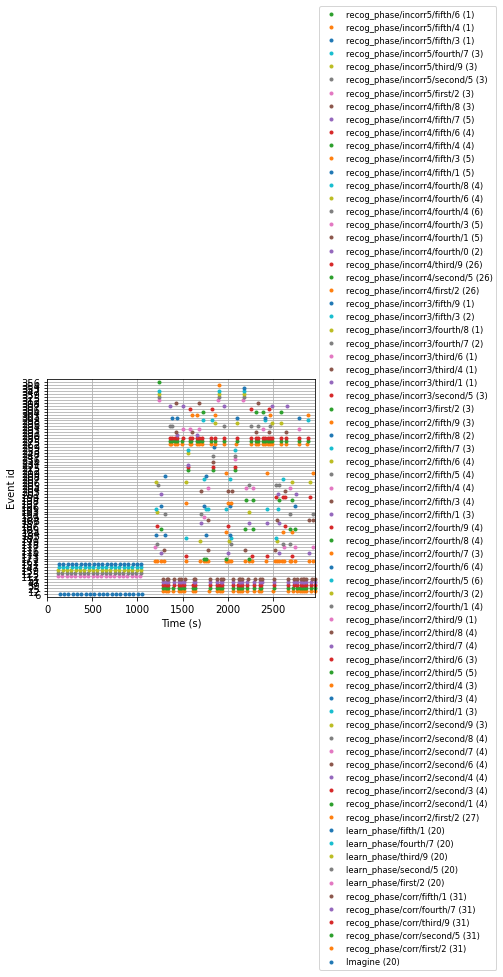

In [40]:
# plotting the events
mne.viz.plot_events(new_triggers[:,:], sfreq=250, first_samp=raw.first_samp, event_id=new_event_id);

### Establishing a time window to show epochs within
The time window we establish span from 0.2 seconds before stimulus onset to 0.5 seconds after stimulus onset. The 200 milliseconds before the onset of the stimulus enables us to examine a baseline of activity without stimulus presentation. The 500 milliseconds after the stimulus onset denote the time in which we expect the effect to occur, since most EEG components arise before the 500 milliseconds mark.

In [54]:
# establishing time window
tmin, tmax = -0.2, 0.5

# choosing only EEG channels for epoching
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False)

In [55]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs = mne.Epochs(raw, new_triggers[:,:], new_event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
570 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 570 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F8', 'FC5', 'FC1', 'FC6', 'T7', 'CP5', 'Oz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F8', 'FC5', 'FC6', 'C4']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting

# Downsampling

In [45]:
# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

# ERP's
Now we can group the epochs by modality (auditory/visual) and take a look at the differences between them!

In [63]:
# now the '/' used in the event IDs comes in handy! To get all epochs with auditory stimuli, we can index 'auditory' across the left/right dimension (and 'visual', of course)
# that way we don't have to specify 'auditory_left' and 'auditory_right' etc.
second_incorr = epochs_resampled['recog_phase/incorr2/second']
fourth__incorr = epochs_resampled['recog_phase/incorr4/fourth']

first__incorr = epochs_resampled['recog_phase/incorr1/first']

# plotting one channel as an example for each modality
five_incorr.plot_image(picks=['Oz']);
five_incorr.plot_image(picks=['Oz']);

first__incorr.plot_image(picks=['Oz']);

KeyError: 'Event name "recog_phase/incorr1/first" could not be found. The following events are present in the data: Imagine, recog_phase/corr/first/2, recog_phase/corr/second/5, recog_phase/corr/third/9, recog_phase/corr/fourth/7, recog_phase/corr/fifth/1, learn_phase/first/2, learn_phase/second/5, learn_phase/third/9, learn_phase/fourth/7, learn_phase/fifth/1, recog_phase/incorr2/first/2, recog_phase/incorr2/second/1, recog_phase/incorr2/second/3, recog_phase/incorr2/second/4, recog_phase/incorr2/second/6, recog_phase/incorr2/second/7, recog_phase/incorr2/second/8, recog_phase/incorr2/second/9, recog_phase/incorr2/third/1, recog_phase/incorr2/third/3, recog_phase/incorr2/third/4, recog_phase/incorr2/third/5, recog_phase/incorr2/third/6, recog_phase/incorr2/third/7, recog_phase/incorr2/third/8, recog_phase/incorr2/third/9, recog_phase/incorr2/fourth/1, recog_phase/incorr2/fourth/3, recog_phase/incorr2/fourth/5, recog_phase/incorr2/fourth/6, recog_phase/incorr2/fourth/7, recog_phase/incorr2/fourth/8, recog_phase/incorr2/fourth/9, recog_phase/incorr2/fifth/1, recog_phase/incorr2/fifth/3, recog_phase/incorr2/fifth/4, recog_phase/incorr2/fifth/5, recog_phase/incorr2/fifth/6, recog_phase/incorr2/fifth/7, recog_phase/incorr2/fifth/8, recog_phase/incorr2/fifth/9, recog_phase/incorr3/first/2, recog_phase/incorr3/second/5, recog_phase/incorr3/third/1, recog_phase/incorr3/third/4, recog_phase/incorr3/third/6, recog_phase/incorr3/fourth/7, recog_phase/incorr3/fourth/8, recog_phase/incorr3/fifth/3, recog_phase/incorr3/fifth/9, recog_phase/incorr4/first/2, recog_phase/incorr4/second/5, recog_phase/incorr4/third/9, recog_phase/incorr4/fourth/0, recog_phase/incorr4/fourth/1, recog_phase/incorr4/fourth/3, recog_phase/incorr4/fourth/4, recog_phase/incorr4/fourth/6, recog_phase/incorr4/fourth/8, recog_phase/incorr4/fifth/1, recog_phase/incorr4/fifth/3, recog_phase/incorr4/fifth/4, recog_phase/incorr4/fifth/6, recog_phase/incorr4/fifth/7, recog_phase/incorr4/fifth/8, recog_phase/incorr5/first/2, recog_phase/incorr5/second/5, recog_phase/incorr5/third/9, recog_phase/incorr5/fourth/7, recog_phase/incorr5/fifth/3, recog_phase/incorr5/fifth/4, recog_phase/incorr5/fifth/6'